In [28]:
%reset

In [29]:
import sys
sys.path.append('/home/users/ids29/DGRB')

In [30]:
import aegis
import numpy as np
import healpy as hp
import torch
import pickle as pk
from astropy import units as u
from astropy import constants as c
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["text.usetex"] = False          # use MathText
rcParams["mathtext.fontset"] = "cm"      # Computer Modern math
rcParams["font.family"] = "serif"
from os import listdir
import os
from sbi.inference import SNPE #, prepare_for_sbi #, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
# from sbi.inference.base import infer
from getdist import plots, MCSamples
import pickle
from scipy.stats import norm, skew, kurtosis, spearmanr
from scipy.integrate import quad, simpson
from joblib import Parallel, delayed
from torch.optim import AdamW
from sbi.neural_nets import posterior_nn
import warnings
from sbi.inference.posteriors import DirectPosterior
from torch.utils.data import DataLoader, TensorDataset, random_split
import copy
from torch.nn.utils import clip_grad_norm_

# torch.set_printoptions(precision=10, sci_mode=True)

%matplotlib inline

In [31]:
# Load test data set
# theta_test = torch.load('/home/users/ids29/DGRB Scripts/DM model/Generate Test Data/combined_test_thetas.pt') # thetas used for test dataset
# # DM signal
# with open('/home/users/ids29/DGRB Scripts/DM model/Generate Test Data/test_data_DM.pkl', 'rb') as f:
#     raw_test_DM = pickle.load(f) 
# Background signal
with open('/home/users/ids29/DGRB Scripts/DM model/Generate Test Data/Emulate ABC paper version 1/test_data_BG.pkl', 'rb') as f:
    raw_test_BG = pickle.load(f) 
# # Overall signal
# with open('/home/users/ids29/DGRB Scripts/DM model/Generate Test Data/combined_test_data.pkl', 'rb') as f:
#     raw_test_overall = pickle.load(f) 




# print(f"theta_test = {theta_test}")

In [32]:
# --- concise, log-binned 1-D energy histogram ---------------------------
def compute_energy_only_histogram(energies, num_bins, energy_range=(1000, 100_000)):
    """
    Log-bin photon energies (MeV) into `num_bins` and return raw counts.

    Parameters
    ----------
    energies      : 1-D iterable (list / np.ndarray / torch.Tensor)
    num_bins      : int, number of logarithmic bins
    energy_range  : (low, high) edges in MeV  (default 1–100 GeV)

    Returns
    -------
    hist : 1-D np.ndarray length `num_bins`  (integer counts)
    """
    edges = np.geomspace(energy_range[0], energy_range[1], num_bins + 1, dtype=np.float32)
    hist, bin_edges = np.histogram(np.asarray(energies, dtype=np.float32), bins=edges)
    return hist.astype(np.float32), bin_edges

In [33]:

N_Ebins = 100
center_mask = 0 # 60 #deg
lat_mask = 0 # 30 #deg 
energy_range = [1_000, 100_000] # MeV

In [34]:
N_side = 64
N_pix = 12*N_side**2
pix_i = np.linspace(0, N_pix-1, N_pix, dtype = 'int')
roi_pix_i = np.where(np.logical_and(hp.rotator.angdist(np.array([np.pi/2, 0]), hp.pix2ang(N_side, pix_i)) >= center_mask*u.deg.to('rad'), np.abs(np.pi/2 - hp.pix2ang(N_side, pix_i)[0]) >= lat_mask*u.deg.to('rad')))[0]


def generate_spectrum(photon_info):
    # Generates normalized spectrum
    
    photon_pixels = hp.ang2pix(N_side, photon_info['angles'][:, 0], photon_info['angles'][:, 1])

    roi_mask = np.isin(photon_pixels, roi_pix_i)
    print(f"Number of 'False' entries in roi_mask = {np.count_nonzero(~roi_mask)}; for full sky expect this value to be 0")
    energies_in_roi = photon_info['energies'][roi_mask]

    energy_hist, bin_edges = compute_energy_only_histogram(energies_in_roi, num_bins=N_Ebins, energy_range=energy_range)
    spectrum = energy_hist / (bin_edges[1:] - bin_edges[:-1])
    spectrum_normalized = spectrum / energies_in_roi.size

    return spectrum_normalized, bin_edges

Number of 'False' entries in roi_mask = 0; for full sky expect this value to be 0


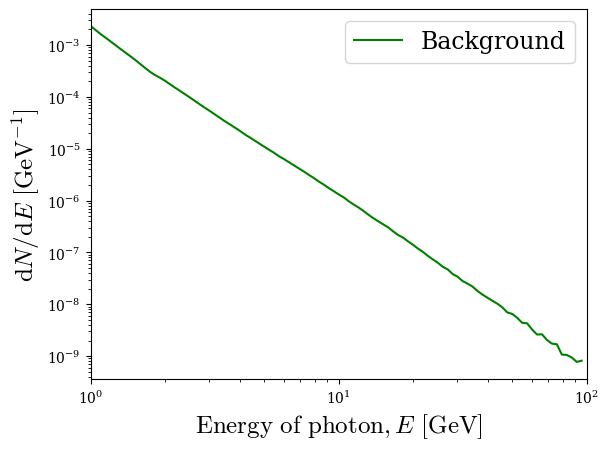

In [35]:
# spectrum_DM, bin_edges_DM = generate_spectrum(raw_test_DM)
spectrum_BG, bin_edges_BG = generate_spectrum(raw_test_BG)
# spectrum_overall, bin_edges_overall = generate_spectrum(raw_test_overall)


# area_under_spectrum = simpson(spectrum_DM, x= bin_edges_DM[:-1])
# print(f"Area under normalized spectrum = {area_under_spectrum}' Expected value = 1")

# plt.loglog(bin_edges_DM[:-1]/1e3, spectrum_DM, color='blue', label='Dark Matter')
plt.loglog(bin_edges_BG[:-1]/1e3, spectrum_BG, color='green', label='Background')
# plt.loglog(bin_edges_overall[:-1]/1e3, spectrum_overall, color='green', label='Combined signal')

plt.xlabel(r'$\mathrm{Energy\ of\ photon, }E\ \mathrm{ [GeV]}$', fontsize=18)
plt.ylabel(r'$\mathrm{d}N / \mathrm{d}E\ [\mathrm{GeV}^{-1}]$', fontsize=18)
plt.xlim(1, 100)
plt.legend(fontsize=17)
plt.show()